# Imports

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp, solve_bvp
from scipy.optimize import minimize
import pandas as pd
import scipy.linalg as la

# setup the print and display options to make displaying easier
np.set_printoptions(precision=5, suppress=True)
pd.set_option("display.precision", 15)
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})
pd.set_option('display.float_format', lambda x: "{0:0.7f}".format(x))
pd.set_option('display.max_columns', None)

# Base Model

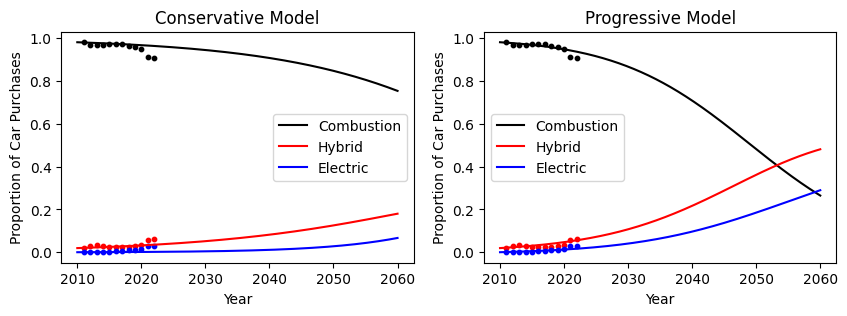

In [4]:
# build model
def model(t, cars, ch, he, ec, hc, eh, ce, c, h, e):
    return np.array([(hc-ch)*cars[0]*cars[1] + (ec-ce)*cars[0]*cars[2] + c,
                     (ch-hc)*cars[0]*cars[1] + (eh-he)*cars[1]*cars[2] + h,
                     (ce-ec)*cars[0]*cars[2] + (he-eh)*cars[1]*cars[2] + e])

# initialize subplots
plt.figure(figsize=(10, 3))

# read in actual data
rel_sales_df = pd.read_csv('rel_sales_df.csv')

#### CONSERVATIVE MODEL ####
# initial conditions
C = 0.9792
H = 0.02
E = 0.0008

# time points
t0 = 0
tf = 50

# constants 
ch = 0.15 # rate from combustion to hybrid
he = 0.1 # rate from hybrid to electric
ec = 0.01 # rate from electric to combustion
hc = 0.1 # rate from hybrid to combustion
eh = 0.01 # rate from electric to hybrid
ce = 0.1 # rate from combustion to electric
c = 0.0 # rate of new combustion
h = 0.0 # rate of new hybrid
e = 0.0 # rate of new electric

# solve ODE
sol = solve_ivp(model, [t0, tf], [C, H, E], args=(ch, he, ec, hc, eh, ce, c, h, e), t_eval=np.linspace(t0, tf, 1000))


# plot actual data
plt.subplot(121)
dot_size = 10
plt.scatter(rel_sales_df['Year'], rel_sales_df['Hybrid_ratio'], color="r", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Combustion_ratio'], color="k", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Electric_ratio'], color="b", s=dot_size)
plt.plot(sol.t + 2010, sol.y[0], label="Combustion", c="k")
plt.plot(sol.t + 2010, sol.y[1], label="Hybrid", c="r")
plt.plot(sol.t + 2010, sol.y[2], label="Electric", c="b")
plt.title("Conservative Model")
plt.xlabel("Year")
plt.ylabel("Proportion of Car Purchases")
plt.legend()


#### PROGRESSIVE MODEL ####
# constants for progressive model
ch = 0.19 # rate from combustion to hybrid
he = 0.2 # rate from hybrid to electric
ec = 0.01 # rate from electric to combustion
hc = 0.1 # rate from hybrid to combustion
eh = 0.18 # rate from electric to hybrid
ce = 0.1 # rate from combustion to electric
c = 0.0 # rate of new combustion
h = 0.0 # rate of new hybrid
e = 0.0007 # rate of new electric

# solve ode
sol2 = solve_ivp(model, [t0, tf], [C, H, E], args=(ch, he, ec, hc, eh, ce, c, h, e), t_eval=np.linspace(t0, tf, 1000))



# plot
plt.subplot(122)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Hybrid_ratio'], color="r", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Combustion_ratio'], color="k", s=dot_size)
plt.scatter(rel_sales_df['Year'], rel_sales_df['Electric_ratio'], color="b", s=dot_size)
plt.plot(sol2.t + 2010, sol2.y[0], label="Combustion", c="k")
plt.plot(sol2.t + 2010, sol2.y[1], label="Hybrid", c="r")
plt.plot(sol2.t + 2010, sol2.y[2], label="Electric", c="b")
plt.title("Progressive Model")
plt.xlabel("Year")
plt.ylabel("Proportion of Car Purchases")
plt.legend()

# save figure
plt.savefig('original_model.png', dpi=200, bbox_inches='tight')
plt.show()

# California Regulation

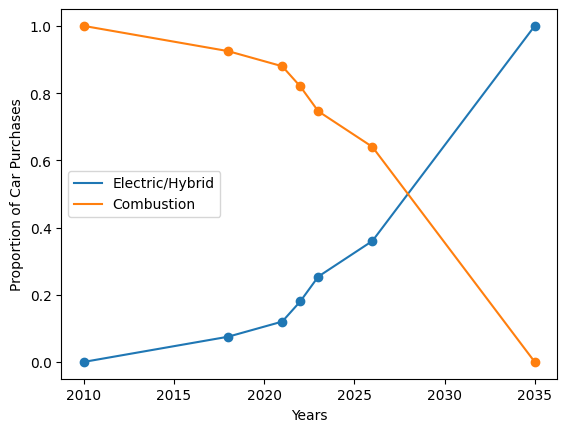

In [6]:
# real data
eh = [0,.075,.12,.18,.254, .36, 1]
c = [1, 1-.075, 1-.12, 1-.18,1-.254, 1-.36, 0]
t = [2010,2018,2021,2022,2023,2026,2035]

# plot
plt.plot(t,eh, label = "Electric/Hybrid")
plt.scatter(t,eh)
plt.plot(t,c, label = "Combustion")
plt.scatter(t,c)
plt.xlabel("Years")
plt.ylabel("Proportion of Car Purchases")
plt.legend()
plt.show()

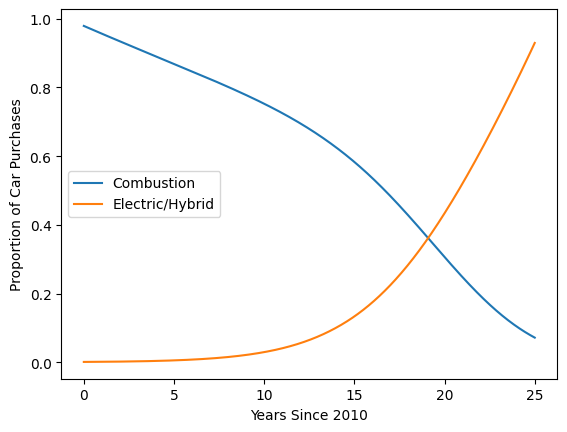

1000
400
Combustion:  0.7523132784873985
Electric:  0.02946421876734881


In [7]:
# build model
def model(t, cars, ec, ce, c, e):
    return np.array([(ec)*cars[0]*cars[1] + c*cars[0],
                     (ce)*cars[0]*cars[1] + e*cars[1]])

# constants
ec = -0.4 # rate from electric to combustion
ce = .3 # rate from combustion to electric
c = -0.023# rate of new combustion
e = 0.1 # rate of new electric

# initial conditions
C = 0.9792
E = 0.0008

# time points
t0 = 0
tf = 25

# solve ODE
sol = solve_ivp(model, [t0, tf], [C,E], args=(ec, ce, c,e), t_eval=np.linspace(t0, tf, 1000))

# plot
plt.plot(sol.t, sol.y[0], label="Combustion")
plt.plot(sol.t, sol.y[1], label="Electric/Hybrid")
plt.xlabel("Years Since 2010")
plt.ylabel("Proportion of Car Purchases")
plt.legend()
plt.show()

# print values at t=10
print(len(sol.y[0]))
year = 2020
time = int((year - 2010) * 1000 / tf)
print(time)
print("Combustion: ", sol.y[0][time])
print("Electric: ", sol.y[1][time])

# Disaster Effect

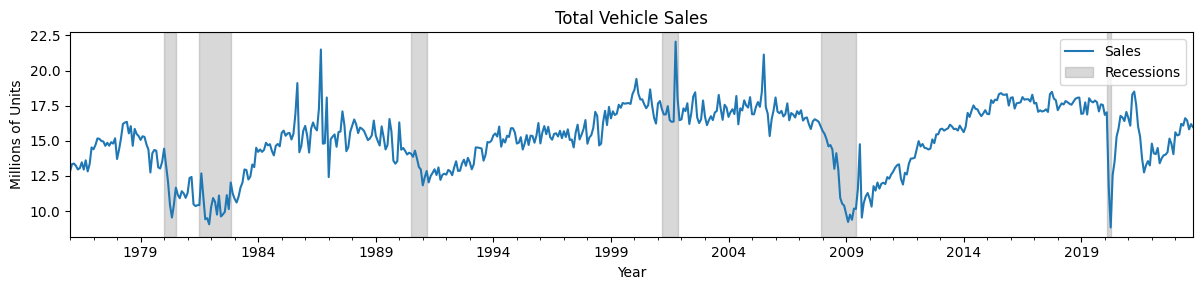

In [8]:
# read car sales data
car_sales = pd.read_csv('TOTALSA.csv')
car_sales['DATE'] = pd.to_datetime(car_sales['DATE']) # convert to datetime format
# read recession dates
recession = pd.read_csv('recession_dates.csv')[['Peaks', 'Troughs']]
# convert to datetime format
recession['Peaks'] = pd.to_datetime(recession['Peaks'])
recession['Troughs'] = pd.to_datetime(recession['Troughs'])

# create figure and plot car sales
fig, ax = plt.subplots(1,1,figsize=(12,3))
car_sales.plot(x='DATE', y='TOTALSA', ax=ax, c='#1f77b4')

# gray out the recession areas
for i in range(recession.shape[0]):
    ax.axvspan(recession.loc[i, 'Peaks'], recession.loc[i, 'Troughs'], alpha=0.3, color='gray')

# label plot
ax.set_title('Total Vehicle Sales')
ax.set_ylabel('Millions of Units')
ax.legend(['Sales', 'Recessions'])
ax.set_xlabel('Year')
plt.tight_layout()
plt.savefig('Total Vehicle Sales')
plt.show()

# charging ports

### setup the data

In [ ]:
# load the charging data
charging_df = pd.read_csv("data/charging.csv")

# load the sales data
sales_df = pd.read_csv("data/vehicle_sales_2000_2023.csv")
sales_df = sales_df.merge(charging_df, on='Year', how='left')
sales_df['Charging Ports'] = sales_df['Charging Ports'].fillna(0).astype(float) / 1000
sales_df['Station Locations'] = sales_df['Station Locations'].fillna(0).astype(float) / 1000
sales_df['Station Locations Ratio'] = sales_df['Station Locations'] / sales_df['Total']

rel_sales_df = sales_df.loc[sales_df['Year'] >= 2011, :].copy()